<a href="https://colab.research.google.com/github/Prakhar314/COL764-Project/blob/main/notebooks/pairwise_evaluate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
!pip install transformers tensorflow-addons

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


### Model

In [4]:
import transformers
from transformers import BertTokenizer, BertConfig, TFBertModel
import tensorflow as tf
import tensorflow_addons as tfa

In [5]:
bert_model_name = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(bert_model_name)

#### Pointwise

In [6]:
def create_inputs(num_nodes,name):
  layers = []
  for layer_name in ['input_ids','token_type_ids','attention_mask']:
    layers.append(tf.keras.layers.Input(shape=(num_nodes,),dtype=tf.int32,name=layer_name+f'_{name}'))
  return layers

def create_model_pairwise(output_bias=None):
    if output_bias is not None:
      output_bias = tf.keras.initializers.Constant(output_bias)
    config = BertConfig(hidden_dropout_prob=0.1)
    bert = TFBertModel.from_pretrained(bert_model_name,config=config)
    bert.save_pretrained('./bert-model/')
    for layer in bert.layers[:]:
      if isinstance(layer, transformers.models.bert.modeling_tf_bert.TFBertMainLayer):
        layer.embeddings.trainable=False
        layer.pooler.trainable=False
        for idx, layer in enumerate(layer.encoder.layer):
            # print(layer)
            # freeze first 10
            if idx in range(10):
                layer.trainable = False
      else:
        layer.trainable = False
              
    input_1 = create_inputs(512,'pair_1')
    input_2 = create_inputs(512,'pair_2')
    bert_out_1 = bert(input_1).last_hidden_state
    bert_out_2 = bert(input_2).last_hidden_state
    cls_1 = tf.keras.layers.Lambda(lambda x:x[:,0,:])(bert_out_1)
    cls_2 = tf.keras.layers.Lambda(lambda x:x[:,0,:])(bert_out_2)
    concated = tf.keras.layers.Concatenate()([cls_1,cls_2])
    # print(avg_q.shape)
    output = tf.keras.layers.Dense(1, activation="sigmoid",bias_initializer=output_bias)(concated)
    model = tf.keras.models.Model(inputs=[input_1,input_2], outputs=[output])
    # opt,schedule = transformers.create_optimizer(num_train_steps=num_train_steps,init_lr=3e-5,adam_beta1=0.9,adam_beta2=0.999,weight_decay_rate=0.01,num_warmup_steps=num_train_steps//10)
    opt = tfa.optimizers.RectifiedAdam(learning_rate=3e-5)
    model.compile(optimizer=opt,
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy(),
                       tf.keras.metrics.AUC(curve="ROC")])
    model.summary()
    return model

#### Load Weights

In [7]:
model = create_model_pairwise()

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids_pair_1 (InputLayer)  [(None, 512)]        0           []                               
                                                                                                  
 token_type_ids_pair_1 (InputLa  [(None, 512)]       0           []                               
 yer)                                                                                             
                                                                                                  
 attention_mask_pair_1 (InputLa  [(None, 512)]       0           []                               
 yer)                                                                                             
                                                                                              

In [8]:
model.load_weights("/content/gdrive/MyDrive/col764/pairwise_best_model_freeze10.h5")

### Load Data

In [9]:
!tar -zxf /content/gdrive/MyDrive/col764/output_qrel_only.tar.gz

In [10]:
!ls /content/gdrive/MyDrive/col764/results

run.desc.test.txt	    run.desc.train.txt	run.query.test.txt.reranked
run.desc.test.txt.reranked  run.query.test.txt	run.query.train.txt


In [59]:
query_file = '/content/gdrive/MyDrive/col764/queries/podcasts_2020_topics_test_query.tsv'

In [60]:
queries = pd.read_csv(query_file,sep='\t',header=None)
queries.columns = ['qnum','query']

In [61]:
queries

,qnum,query
0,9,trump call ukrainian president
1,10,boeing 737 crash causes
2,11,how to cook turkey
3,12,imran khan career
4,13,drug addiction recovery
5,14,near death experiences
6,15,podcast about podcasts
7,16,causes and prevention of wildfires
8,17,time between meetings
9,18,women in stem


In [62]:
results_file = '/content/gdrive/MyDrive/col764/results/run.query.test.txt'

In [63]:
bm25_ranks = pd.read_csv(results_file,sep=' ',header=None)
bm25_ranks.columns = ['qnum','qid','epid','rank','score','runid']

In [16]:
bm25_ranks

,qnum,qid,epid,rank,score,runid
0,9,Q0,spotify:episode:6O8djf3RL94yNfaoWqvk3r_840.0,1,16.569401,Anserini
1,9,Q0,spotify:episode:3gJ0fBXYRryWAjgwxY4q6C_240.0,2,16.302999,Anserini
2,9,Q0,spotify:episode:6svv5L5kRn8groSsM8gkpc_3180.0,3,15.984800,Anserini
3,9,Q0,spotify:episode:4JqqVFhNjtlwoIMl5tvL8R_780.0,4,15.275800,Anserini
4,9,Q0,spotify:episode:3gJ0fBXYRryWAjgwxY4q6C_0.0,5,14.734600,Anserini
...,...,...,...,...,...,...
47753,58,Q0,spotify:episode:30j4F0dABykbXJuGevrfNB_1920.0,996,4.663695,Anserini
47754,58,Q0,spotify:episode:3ALoC0SU00c8RtxQHohesZ_1440.0,997,4.663694,Anserini
47755,58,Q0,spotify:episode:3ALoC0SU00c8RtxQHohesZ_420.0,998,4.663693,Anserini
47756,58,Q0,spotify:episode:3bieaciVail62osQ0YC8JE_1380.0,999,4.663692,Anserini


In [17]:
bm25_ranks = bm25_ranks[bm25_ranks['rank']<21].reset_index(drop=True)

In [18]:
episode_contents = {k:None for k in bm25_ranks.epid.unique()}

In [19]:
!ls /content/

bert-model  gdrive  output_copy  sample_data  trec_eval


In [20]:
import json
for root, dirs, files in os.walk('/content/output_copy'):
  files.sort()
  for file in files:
    # print(file)
    with open(root+"/"+file,'r') as f:
      episode_segments = json.load(f)
      for segment in episode_segments:
        if segment['id'] in episode_contents:
          episode_contents[segment['id']] = segment['contents']

In [21]:
len(sorted(list(episode_contents.keys())))

1000

In [22]:
bm25_ranks['segment'] = bm25_ranks['epid'].map(episode_contents)

In [23]:
bm25_ranks=bm25_ranks.merge(queries,how='left',left_on='qnum',right_on='qnum')

In [24]:
bm25_ranks = bm25_ranks.merge(bm25_ranks[['qnum','segment','epid']],how='left',left_on='qnum',right_on='qnum')

Distribution of token sizes

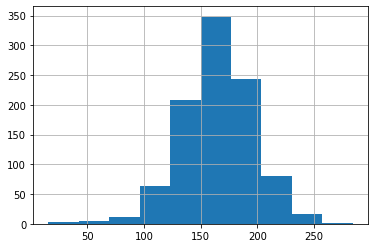

In [25]:
pd.DataFrame(bm25_ranks['segment_y'].unique()).apply(lambda x:len(x[0].split()),axis=1).hist()

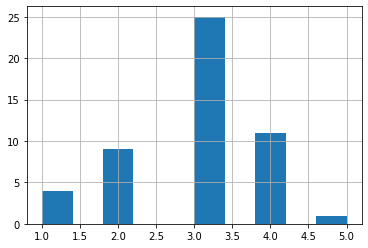

In [26]:
pd.DataFrame(bm25_ranks['query'].unique()).apply(lambda x:len(x[0].split()),axis=1).hist()

### Reranking

In [27]:
q_trunc = 64
p_trunc = 512-64+1

In [28]:
import gc
import numpy as np

In [30]:
q = tokenizer(bm25_ranks['query'].values.tolist(), return_tensors="tf",padding="max_length",max_length=q_trunc,truncation=True)
p_1 = tokenizer(bm25_ranks['segment_x'].values.tolist(), return_tensors="tf",padding="max_length",max_length=p_trunc,truncation=True)
p_2 = tokenizer(bm25_ranks['segment_y'].values.tolist(), return_tensors="tf",padding="max_length",max_length=p_trunc,truncation=True)
X_test = []
for id in ['input_ids','token_type_ids','attention_mask']:
  X_test.append(tf.concat([q[id],p_1[id][:,1:]],1))
for id in ['input_ids','token_type_ids','attention_mask']:
  X_test.append(tf.concat([q[id],p_2[id][:,1:]],1))
q = None
p_1 = None
p_2 = None
gc.collect()

0

In [31]:
with tf.device('/device:GPU:0'):
  scores = model.predict(X_test,batch_size=8,verbose=1)

2500/2500 [==============================] - 2834s 1s/step


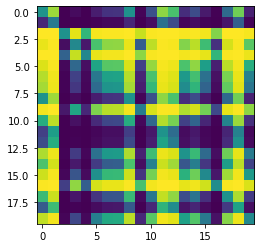

In [32]:
plt.imshow(np.abs(0.5-scores[:400]).reshape(20,20))

#### Scores to rank

In [33]:
bm25_ranks['score'] = scores

In [34]:
bm25_ranks = bm25_ranks.drop(['segment_x','segment_y','query'],axis=1)

In [35]:
def getRanks(results):
  pivot = results.pivot('epid_x','epid_y','score')
  pivot_t = pivot.T
  np.fill_diagonal(pivot.values,1)
  results_ranked = pd.DataFrame(((pivot>pivot_t) & (pivot>0.5)).sum(axis=1) + pivot.mean(axis=1))
  results_ranked = results_ranked.reset_index()
  dropped = results.drop(['epid_y','score'],axis=1).drop_duplicates()
  results_ranked = results_ranked.merge(dropped,how='left',left_on='epid_x',right_on='epid_x')
  results_ranked.columns = ['epid','score','qnum','qid','rank','runid']
  return results_ranked

In [36]:
bm25_ranks = bm25_ranks.groupby('qnum').apply(getRanks).reset_index(drop=True)
bm25_ranks[['rank','qnum']] = bm25_ranks[['rank','qnum']].astype(np.int32)
bm25_ranks

,epid,score,qnum,qid,rank,runid
0,spotify:episode:0DNqe9Rnj8gP0fRCOsWxfT_1440.0,13.637088,9,Q0,16,Anserini
1,spotify:episode:0nhWyQfESIgR4X8nQZa08y_1980.0,12.600861,9,Q0,20,Anserini
2,spotify:episode:14RFTGKJ9RQlxtJJ6MhNXs_300.0,10.578251,9,Q0,7,Anserini
3,spotify:episode:1jvy4Usn4Z8awRi3gpw0iQ_900.0,17.882542,9,Q0,17,Anserini
4,spotify:episode:1nu9RsgfYsbNb7CDmHlvKx_1320.0,9.550723,9,Q0,8,Anserini
...,...,...,...,...,...,...
995,spotify:episode:5xDfrpC4pmkHBVf28JYKv1_120.0,12.542030,58,Q0,14,Anserini
996,spotify:episode:62DJcqXZ65VsObZPkv4ZIJ_4140.0,14.651581,58,Q0,20,Anserini
997,spotify:episode:73jHKrU0ZDmI2SNCsYyCsz_2160.0,15.685263,58,Q0,4,Anserini
998,spotify:episode:76ezvYdkEkPsWO5x5PwUjz_5100.0,6.433411,58,Q0,12,Anserini


In [37]:
bm25_ranks = bm25_ranks.sort_values(['qnum','score'], ascending = [True, False]).reset_index(drop=True)

In [38]:
bm25_ranks['rank'] = bm25_ranks.groupby('qnum')['score'].rank(ascending=False).astype(np.int16)

In [39]:
bm25_ranks = bm25_ranks[['qnum',	'qid',	'epid',	'rank',	'score',	'runid']]
bm25_ranks

,qnum,qid,epid,rank,score,runid
0,9,Q0,spotify:episode:6svv5L5kRn8groSsM8gkpc_3180.0,1,19.963267,Anserini
1,9,Q0,spotify:episode:3gJ0fBXYRryWAjgwxY4q6C_0.0,2,18.926262,Anserini
2,9,Q0,spotify:episode:1jvy4Usn4Z8awRi3gpw0iQ_900.0,3,17.882542,Anserini
3,9,Q0,spotify:episode:2wlZZPXaCiEBGB0TCPk7VL_780.0,4,16.793030,Anserini
4,9,Q0,spotify:episode:4JqqVFhNjtlwoIMl5tvL8R_780.0,5,15.740162,Anserini
...,...,...,...,...,...,...
995,58,Q0,spotify:episode:4gcfeQhSsN3GWX0D8vilrq_900.0,16,4.293690,Anserini
996,58,Q0,spotify:episode:16YiYSDRL1cQeizu7lw9Lk_480.0,17,3.262148,Anserini
997,58,Q0,spotify:episode:5pCYtmPK749a2vjErb8I1P_3840.0,18,2.237336,Anserini
998,58,Q0,spotify:episode:0CwYbNjJlIYF49WAMyAg4u_240.0,19,1.107870,Anserini


In [40]:
reranked_file = results_file+'.reranked' + '.pair' + '.query' + '.threshed'

In [41]:
bm25_ranks.to_csv(reranked_file, sep = '\t', index=False)

In [42]:
!git clone https://github.com/usnistgov/trec_eval

fatal: destination path 'trec_eval' already exists and is not an empty directory.


In [43]:
!cd trec_eval;make

make: 'trec_eval' is up to date.


In [56]:
!./trec_eval/trec_eval  -q -c -M1000 -m ndcg_cut.5 /content/gdrive/MyDrive/col764/qrels/2020_test_qrels.list {reranked_file}

ndcg_cut_5            	10	0.3008
ndcg_cut_5            	11	0.1568
ndcg_cut_5            	12	0.0000
ndcg_cut_5            	13	0.1461
ndcg_cut_5            	14	0.6371
ndcg_cut_5            	15	0.0000
ndcg_cut_5            	16	0.1386
ndcg_cut_5            	17	0.3392
ndcg_cut_5            	18	0.4406
ndcg_cut_5            	19	0.7876
ndcg_cut_5            	20	0.3815
ndcg_cut_5            	21	0.6308
ndcg_cut_5            	22	0.1985
ndcg_cut_5            	23	0.1696
ndcg_cut_5            	24	0.6622
ndcg_cut_5            	25	0.6992
ndcg_cut_5            	26	0.9026
ndcg_cut_5            	27	0.4709
ndcg_cut_5            	28	0.5000
ndcg_cut_5            	29	0.6386
ndcg_cut_5            	30	0.1598
ndcg_cut_5            	31	0.0000
ndcg_cut_5            	32	0.0000
ndcg_cut_5            	33	0.2891
ndcg_cut_5            	34	0.1630
ndcg_cut_5            	35	0.3107
ndcg_cut_5            	36	0.2843
ndcg_cut_5            	37	0.5770
ndcg_cut_5            	38	0.4765
ndcg_cut_5            	39	0.2120
ndcg_cut_5

In [57]:
!./trec_eval/trec_eval  -q -c -m ndcg_cut.5  /content/gdrive/MyDrive/col764/qrels/2020_test_qrels.list {results_file}

ndcg_cut_5            	10	0.6302
ndcg_cut_5            	11	0.3383
ndcg_cut_5            	12	0.2140
ndcg_cut_5            	13	0.0000
ndcg_cut_5            	14	0.7945
ndcg_cut_5            	15	0.0000
ndcg_cut_5            	16	0.1918
ndcg_cut_5            	17	0.0000
ndcg_cut_5            	18	0.0000
ndcg_cut_5            	19	0.7174
ndcg_cut_5            	20	0.6740
ndcg_cut_5            	21	0.4979
ndcg_cut_5            	22	0.1556
ndcg_cut_5            	23	0.0000
ndcg_cut_5            	24	0.2517
ndcg_cut_5            	25	0.6399
ndcg_cut_5            	26	0.7021
ndcg_cut_5            	27	0.4790
ndcg_cut_5            	28	0.6070
ndcg_cut_5            	29	0.7154
ndcg_cut_5            	30	0.1598
ndcg_cut_5            	31	0.0000
ndcg_cut_5            	32	0.1091
ndcg_cut_5            	33	0.3493
ndcg_cut_5            	34	0.2140
ndcg_cut_5            	35	0.3284
ndcg_cut_5            	36	0.5932
ndcg_cut_5            	37	0.2953
ndcg_cut_5            	38	0.9076
ndcg_cut_5            	39	0.4480
ndcg_cut_5

In [58]:
!ls /content/gdrive/MyDrive/col764/results/

run.desc.test.txt	    run.query.test.txt.reranked
run.desc.test.txt.reranked  run.query.test.txt.reranked.pair.query
run.desc.train.txt	    run.query.train.txt
run.query.test.txt
